## Import libraries

In [13]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from transformers import BertTokenizerFast, BertForTokenClassification

print(torch.__version__)

1.13.0


## Get data

The dataset is acquired from Kaggle: https://www.kaggle.com/datasets/rajnathpatel/ner-data?resource=download

In [2]:
df = pd.read_csv('ner.csv')
df.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


## EDA

In [3]:
labels = [i.split() for i in df['labels'].values.tolist()]
unique_labels = set()
for label in labels:
    for i in label:
        unique_labels.add(i)

print(f'Number of unique labels: {len(unique_labels)}')

Number of unique labels: 17


In [4]:
labels_to_ids = {k:v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v:k for v, k in enumerate(sorted(unique_labels))}

print(labels_to_ids)

{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}


In total, there are 9 entity categories, which are:

1. geo for geographical entity
2. org for organization entity
3. per for person entity
4. gpe for geopolitical entity
5. tim for time indicator entity
6. art for artifact entity
7. eve for event entity
8. nat for natural phenomenon entity
9. O is assigned if a word doesn’t belong to any entity.

Each entity category is preceded by an IOB tagging,
1. I - intermediate
2. B - beginning

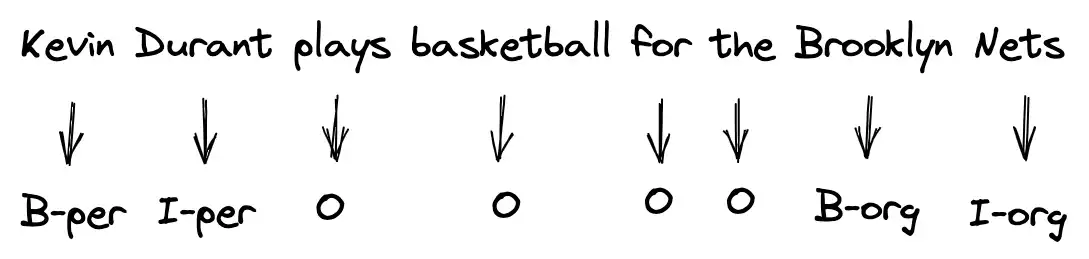

Initialize tokenizer

In [6]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## The general approach

Tokenization

In [37]:
text = df['text'].values.tolist()
example = text[36]
print(example)

Prime Minister Geir Haarde has refused to resign or call for early elections .


In [38]:
text_tokenized = tokenizer(example, padding = 'max_length', 
                           max_length = 512,
                           truncation = True,
                           return_tensors = 'pt')

print(text_tokenized)

{'input_ids': tensor([[  101,  3539,  2704, 16216,  4313,  5292,  4232,  2063,  2038,  4188,
          2000, 12897,  2030,  2655,  2005,  2220,  3864,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

BERT has a few special tokens, namely:
1. 101 - [CLS]
2. 102 - [SEP]
3. 0 - [PAD]

The id outputs are:
1. input_ids: Representation of tokens in a sequence.
2. token_ids: Identify the sequence that the token belongs to. Since we only have one sequence per text, all values of token_type_ids will be 0.
3. attention_mask: To identify whether the token is a real token or padded token.

With the above, we can decode the tensor to return the text

In [39]:
print(tokenizer.decode(text_tokenized.input_ids[0]))

[CLS] prime minister geir haarde has refused to resign or call for early elections. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Label adjustment

Label adjustment is important because once the tokenization step is done, the length of the sequence no longer matches the length of the original label. Under the hood, the BERT tokenizer splits one word into one or more meaningful subwords, for e.g.

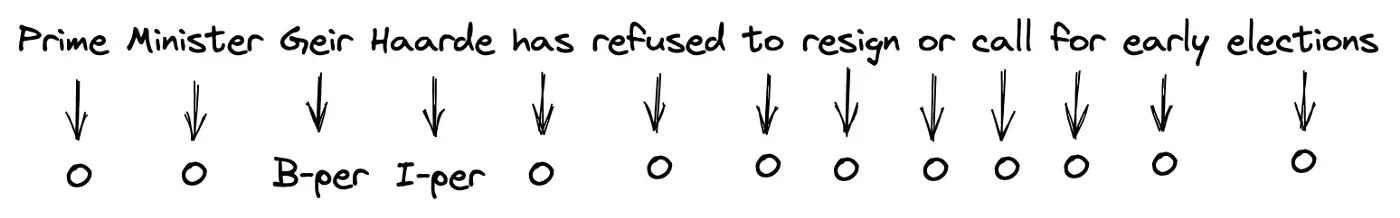

The sentence has a total of 13 words and will therefore have 13 labels. However, the results are different after tokenization, which is a problem. Here are the labels post tokenization:

In [41]:
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))

['[CLS]', 'prime', 'minister', 'ge', '##ir', 'ha', '##ard', '##e', 'has', 'refused', 'to', 'resign', 'or', 'call', 'for', 'early', 'elections', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

The main problems are:
1. The addition of special tokens
2. Some tokens are split into sub-words, especially uncommon words.

We can adjust the labels by utilizing word_ids from the tokenization process.

In [42]:
word_ids = text_tokenized.word_ids()
print(tokenizer.convert_ids_to_tokens(text_tokenized['input_ids'][0]))
print(word_ids)

['[CLS]', 'prime', 'minister', 'ge', '##ir', 'ha', '##ard', '##e', 'has', 'refused', 'to', 'resign', 'or', 'call', 'for', 'early', 'elections', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

The aim is to provide a label of the first sub-word of each splitted token. The continuation sub-word will then have a label of -100, and token_ids without word_ids will also be labelled with -100. We then define and train our model before using it to run inferences.

## Execution of approach

In [7]:
def align_labels(texts, labels, 
                 labels_to_ids = labels_to_ids, 
                 label_all_tokens = False, 
                 tokenizer = tokenizer):
    """
    Align the labels to corresponding words post tokenization.

    Args:
    texts: list of strings
    labels: list of strings
    labels_to_ids: dictionary mapping labels to ids
    label_all_tokens: if True, all tokens are treated as labels
    tokenizer: a function to turn strings into id's

    Returns:
    label_ids
    """
    tokenized_inputs = tokenizer(texts, padding = 'max_length',
                                 max_length = 512, truncation = True)
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx, label_ids = None, []
    
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
            
        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        
        previous_word_idx = word_idx
    
    return label_ids

Create PyTorch dataset class to batch the dataset to the model

In [8]:
class DataSequence(torch.utils.data.Dataset):
    
    def __init__(self, df):
        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding = 'max_length',
                               max_length = 512,
                               truncation = True,
                               return_tensors = 'pt') for i in txt]
        self.labels = [align_labels(i,j) for i, j in zip(txt, lb)]
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_data(self, idx):
        return self.texts[idx]
    
    def get_batch_labels(self, idx):
        return torch.LongTensor(self.labels[idx])
    
    def __getitem__(self, idx):
        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_data, batch_labels

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_no_train = train_test_split(df, test_size = 0.4, random_state = 2022, shuffle = True)
df_val, df_test = train_test_split(df_no_train, test_size = 0.5, random_state = 2022, shuffle = True)

## Model development
We will be using a pre-trained model from HuggingFace - the BertForTokenClassification model wraps around the BERT model and adds a few linear layers for token classification.

In [10]:
class BertModel(torch.nn.Module):
    def __init__(self):
        super(BertModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                               num_labels = len(unique_labels))
    def forward(self, input_id, mask, label):
        output = self.bert(input_ids = input_id, 
                           attention_mask = mask,
                           labels = label,
                           return_dict = False)
        return output

## Model training

In [11]:
BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 0.0001

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

def train(model, df_train, df_val, batch_size = BATCH_SIZE,
          epochs = EPOCHS, learning_rate = LEARNING_RATE):
    """Function to finetune BERT model

    Args:
        model (model_class): BERT model
        df_train (dataframe): train dataset
        df_val (dataframe): _test dataset
        batch_size (integer, optional): Batch size for dataloader. Defaults to BATCH_SIZE.
        epochs (integer, optional): Number of epochs to train. Defaults to EPOCHS.
        learning_rate (float, optional): Learning rate for training. Defaults to LEARNING_RATE.
    """
    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size)
    
    device = get_device()
    print(f'Device: {device}')
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr = learning_rate)
    
    best_acc, best_loss = 0, 1000
    
    for epoch in range(epochs):
        total_acc_train, total_loss_train = 0, 0
        model.train()
        
        for train_data, train_label in tqdm(train_loader):
            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)
            
            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)
            
            for i in range(logits.shape[0]):
                logits_clean = logits[i][train_label[i] != -100]
                label_clean = train_label[i][train_label[i] != -100]
                
                predictions = logits_clean.argmax(dim = 1)
                acc = (predictions == label_clean).float().mean()
                total_acc_train += acc
                total_loss_train += loss.item()
            
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        total_acc_val, total_loss_val = 0, 0
        
        for val_data, val_label in tqdm(val_loader):
            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)
            
            loss, logits = model(input_id, mask, val_label)
            
            for i in range(logits.shape[0]):
                logits_clean = logits[i][val_label[i]!= -100]
                label_clean = val_label[i][val_label[i]!= -100]
                
                predictions = logits_clean.argmax(dim = 1)
                acc = (predictions == label_clean).float().mean()
                total_acc_val += acc
                total_loss_val += loss.item()
        
        val_accuracy = total_acc_val/len(df_val)
        val_loss = total_loss_val/len(df_val)
        
        print(f'Epoch: {epoch+1} | Validation Loss: {val_loss:.4f} | Validation accuracy: {val_accuracy:.4f}')
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")

In [14]:
model = BertModel()
train(model, df_train, df_val)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Device: mps


 73%|███████▎  | 10526/14388 [1:24:00<30:49,  2.09it/s] 


KeyboardInterrupt: 

## Model evaluation

In [ ]:
def evaluate(model, df_test):
    test_dataset = DataSequence(df_test)
    test_loader = DataLoader(test_dataset, batch_size = 1)
    device = get_device()
    print(f'Device used: {device}')
    
    total_acc_test = 0.0
    
    for test_data, test_label in test_loader:
        test_label = test_label.to(device)
        mask = test_data['attention_mask'].squeeze(1).to(device)
        input_id = test_data['input_ids'].squeeze(1).to(device)
        loss, logits = model(input_id, mask, test_label)
        
        for i in range(logits.shape[0]):
            logits_clean = logits[i][test_label[i] != -100]
            label_clean = test_label[i][test_label[i]!= -100]
            predictions = logits_clean.argmax(dim=1)
            acc = (predictions==label_clean).float().mean()
            total_acc_test += acc
    
    print(f'Test accuracy: {total_acc_test/len(df_test):.3f}')